# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 16.7 MB 41.3 MB/s 
     |████████████████████████████████| 6.3 MB 49.8 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 2.1 MB 5.1 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase1_all.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
OCT_poly1 = Polygon([(13.1, 15.8), (13.1, 13.4), (20.6, 13.4), (20.6, 15.8)])

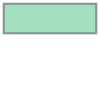

In [ ]:
OCT_poly1

In [ ]:
OCT_poly2 = Polygon([(13.3, 11.6), (13.3, 3.7), (21.3, 3.7), (21.3, 11.6)])

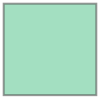

In [ ]:
OCT_poly2

In [ ]:
OCT_poly3 = Polygon([(23, 12.7), (23, 9.1), (27.8, 9.1), (27.8, 12.7)])

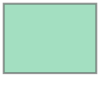

In [ ]:
OCT_poly3

## MultiPolygon Creation

In this example there are two separate sections for the machines. So multiple polygons must be created and subsequently combined to create a MultiPolygon.

In [ ]:
OCT_multipoly = MultiPolygon([OCT_poly1, OCT_poly2, OCT_poly3])

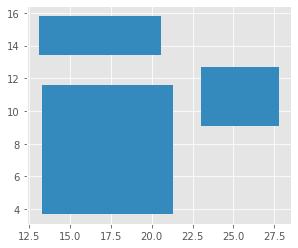

In [ ]:
 p = gpd.GeoSeries(OCT_multipoly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dftest['newfrom'] = lookup(dftest['from'], format='%d/%m/%Y, %H:%M:%S')
dftest['newto'] = lookup(dftest['to'], format='%d/%m/%Y, %H:%M:%S')

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient',
 'Location',
 'from',
 'to',
 'xlocation',
 'ylocation',
 'newfrom',
 'newto']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
OCT_multipoly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(OCT_multipoly))

In [ ]:
OCT_multipoly_gdf

,geometry
0,"MULTIPOLYGON (((13.10000 15.80000, 13.10000 13..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
OCT_join = gpd.sjoin(gdf, OCT_multipoly_gdf, how = 'inner')
OCT_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
30,G0132,"20.224,5.818","08/11/2021, 12:55:44","08/11/2021, 12:55:48",20.224,5.818,2021-11-08 12:55:44,2021-11-08 12:55:48,POINT (20.22400 5.81800),0
31,G0132,"18.637,5.499","08/11/2021, 12:55:48","08/11/2021, 12:57:07",18.637,5.499,2021-11-08 12:55:48,2021-11-08 12:57:07,POINT (18.63700 5.49900),0
32,G0132,"18.275,4.569","08/11/2021, 12:57:07","08/11/2021, 12:59:57",18.275,4.569,2021-11-08 12:57:07,2021-11-08 12:59:57,POINT (18.27500 4.56900),0
33,G0132,"18.098,5.837","08/11/2021, 12:59:57","08/11/2021, 13:00:10",18.098,5.837,2021-11-08 12:59:57,2021-11-08 13:00:10,POINT (18.09800 5.83700),0
34,G0132,"18.291,4.712","08/11/2021, 13:00:10","08/11/2021, 13:09:47",18.291,4.712,2021-11-08 13:00:10,2021-11-08 13:09:47,POINT (18.29100 4.71200),0
...,...,...,...,...,...,...,...,...,...,...
76642,Test,"20.684,7.131","26/11/2021, 16:41:11","26/11/2021, 16:41:24",20.684,7.131,2021-11-26 16:41:11,2021-11-26 16:41:24,POINT (20.68400 7.13100),0
76643,Test,"19.735,5.45","26/11/2021, 16:41:24","26/11/2021, 16:53:54",19.735,5.45,2021-11-26 16:41:24,2021-11-26 16:53:54,POINT (19.73500 5.45000),0
76645,Test,"19.747,5.982","26/11/2021, 16:54:05","26/11/2021, 17:46:23",19.747,5.982,2021-11-26 16:54:05,2021-11-26 17:46:23,POINT (19.74700 5.98200),0
76646,Test,"19.953,4.284","26/11/2021, 17:46:23","26/11/2021, 17:46:45",19.953,4.284,2021-11-26 17:46:23,2021-11-26 17:46:45,POINT (19.95300 4.28400),0


## More data cleaning

In [ ]:
discard = ['f', 'T']
OCT_join = OCT_join[~OCT_join.Patient.str.contains(('|'.join(discard)))]
OCT_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
30,G0132,"20.224,5.818","08/11/2021, 12:55:44","08/11/2021, 12:55:48",20.224,5.818,2021-11-08 12:55:44,2021-11-08 12:55:48,POINT (20.22400 5.81800),0
31,G0132,"18.637,5.499","08/11/2021, 12:55:48","08/11/2021, 12:57:07",18.637,5.499,2021-11-08 12:55:48,2021-11-08 12:57:07,POINT (18.63700 5.49900),0
32,G0132,"18.275,4.569","08/11/2021, 12:57:07","08/11/2021, 12:59:57",18.275,4.569,2021-11-08 12:57:07,2021-11-08 12:59:57,POINT (18.27500 4.56900),0
33,G0132,"18.098,5.837","08/11/2021, 12:59:57","08/11/2021, 13:00:10",18.098,5.837,2021-11-08 12:59:57,2021-11-08 13:00:10,POINT (18.09800 5.83700),0
34,G0132,"18.291,4.712","08/11/2021, 13:00:10","08/11/2021, 13:09:47",18.291,4.712,2021-11-08 13:00:10,2021-11-08 13:09:47,POINT (18.29100 4.71200),0
...,...,...,...,...,...,...,...,...,...,...
76595,R1089,"14.389,5.425","12/11/2021, 12:24:38","12/11/2021, 12:25:03",14.389,5.425,2021-11-12 12:24:38,2021-11-12 12:25:03,POINT (14.38900 5.42500),0
76596,R1089,"13.713,6.432","12/11/2021, 12:25:03","12/11/2021, 12:25:05",13.713,6.432,2021-11-12 12:25:03,2021-11-12 12:25:05,POINT (13.71300 6.43200),0
76597,R1089,"13.451,7.728","12/11/2021, 12:25:05","12/11/2021, 12:25:08",13.451,7.728,2021-11-12 12:25:05,2021-11-12 12:25:08,POINT (13.45100 7.72800),0
76598,R1089,"13.494,10.157","12/11/2021, 12:25:08","12/11/2021, 12:25:10",13.494,10.157,2021-11-12 12:25:08,2021-11-12 12:25:10,POINT (13.49400 10.15700),0


## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
dfgrouped = OCT_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58
...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:53:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal
...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:53:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                         1039
mean     0 days 00:41:21.677574590
std      0 days 00:19:11.344388425
min                0 days 00:00:02
25%                0 days 00:28:12
50%                0 days 00:39:05
75%         0 days 00:51:52.500000
max                0 days 04:53:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:39:59.833333333
morning     0 days 00:42:25.692967409
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:40:46.467479674
Tuesday,0 days 00:41:34.370892018
Wednesday,0 days 00:42:57.785365853
Thursday,0 days 00:43:09.024875621
Friday,0 days 00:37:58.683908045
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
246
Tuesday
213
Wednesday
205
Thursday
201
Friday
174
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday,morning,12
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday,morning,13
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday,morning,11
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday,morning,11
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday,morning,12
...,...,...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday,morning,13
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday,afternoon,14
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday,afternoon,14
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday,afternoon,14


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:44:09.092857142
11   0 days 00:42:37.719211822
12   0 days 00:40:38.518716577
13   0 days 00:43:24.641509433
14   0 days 00:41:44.601036269
15   0 days 00:41:03.247368421
16   0 days 00:32:37.583333333
17             0 days 00:32:53
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
140
Eleven
203
Twelve
187
One
53
Two
193
Three
190
Four
72


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:43:17.131004366
R   0 days 00:37:36.346590909
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
687
Medical Retinal
352


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday,morning,12,G,36.2167
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday,morning,13,G,29.0167
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday,morning,11,G,54.8667
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday,morning,11,G,52.1167
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday,morning,12,G,53.5333
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday,morning,13,R,31.0667
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday,afternoon,14,R,12.0000
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday,afternoon,14,R,23.1500
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday,afternoon,14,R,49.3000


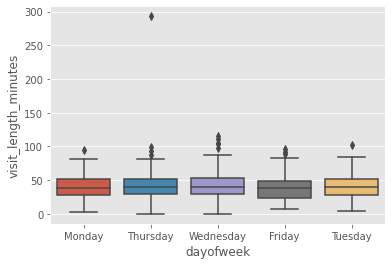

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

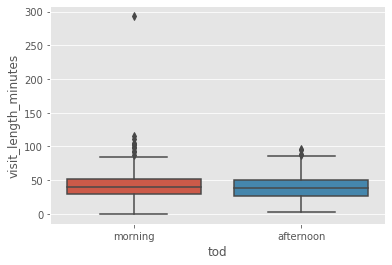

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

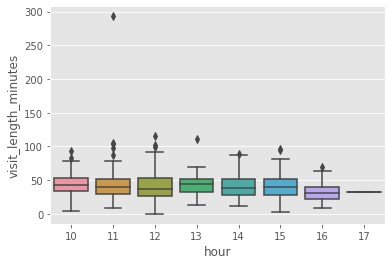

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

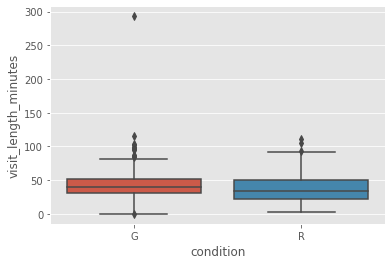

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 15
newfrom                 15
newto                   15
visit_length            15
start_day               15
end_day                 15
sameday                 15
dayofweek               15
tod                     15
hour                    15
condition               15
visit_length_minutes    15
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday,morning,12,G,36.2167
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday,morning,13,G,29.0167
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday,morning,11,G,54.8667
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday,morning,11,G,52.1167
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday,morning,12,G,53.5333
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday,morning,13,R,31.0667
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday,afternoon,14,R,12.0000
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday,afternoon,14,R,23.1500
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday,afternoon,14,R,49.3000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

40.798031623104286
40.798031623104286


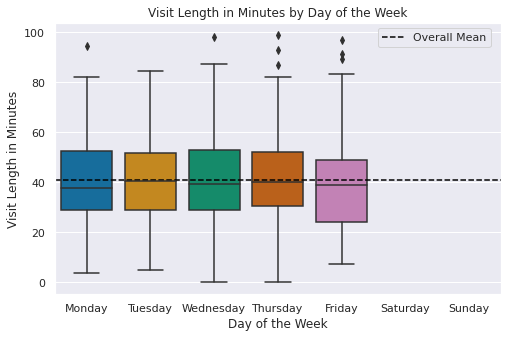

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

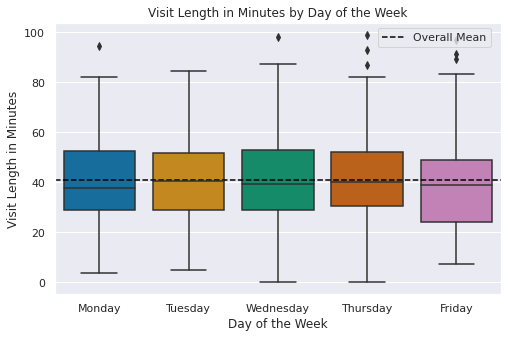

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

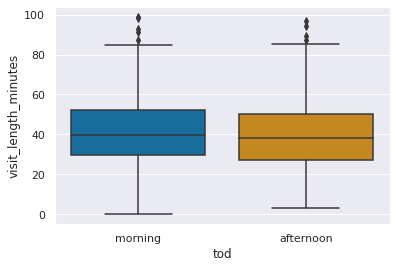

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

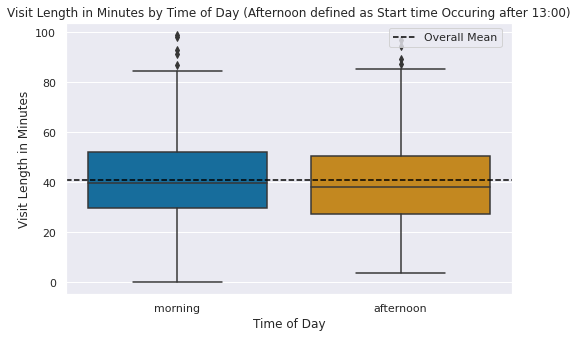

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

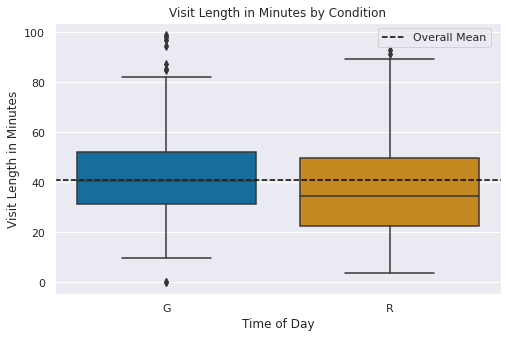

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

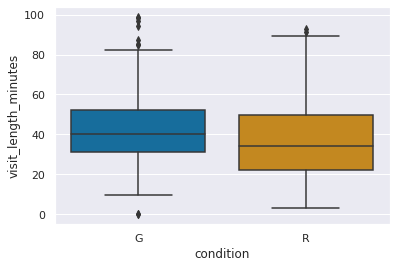

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

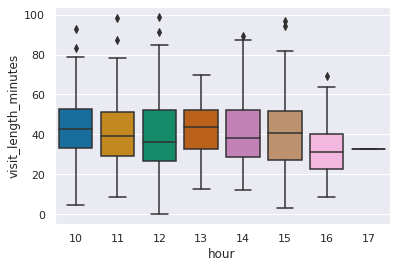

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

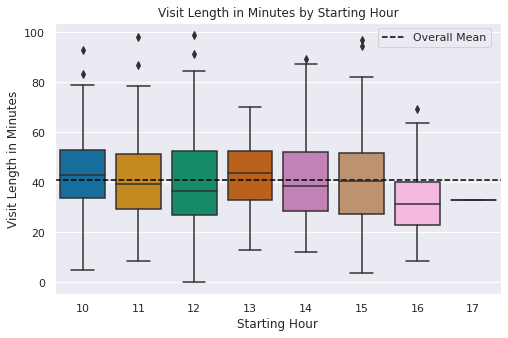

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                 1,033.0000
mean                                     40.7980
std                                      16.9535
min                                       0.0333
25%                                      28.1667
50%                                      39.0500
75%                                      51.7167
max                                      98.8833
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                 1,039.0000
mean                                     41.3613
std                                      19.1891
min                                       0.0333
25%                                      28.2000
50%                                      39.0833
75%                                      51.8750
max                                     293.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

39.083333333333336

In [ ]:
df_outliers['visit_length'].describe()

count                         1033
mean     0 days 00:40:47.881897386
std      0 days 00:16:57.209231062
min                0 days 00:00:02
25%                0 days 00:28:10
50%                0 days 00:39:03
75%                0 days 00:51:43
max                0 days 01:38:53
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                         1039
mean     0 days 00:41:21.677574590
std      0 days 00:19:11.344388425
min                0 days 00:00:02
25%                0 days 00:28:12
50%                0 days 00:39:05
75%         0 days 00:51:52.500000
max                0 days 04:53:00
Name: visit_length, dtype: object

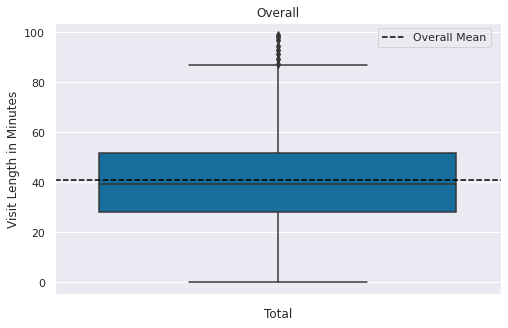

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
140
Eleven
200
Twelve
185
One
52
Two
193
Three
190
Four
72


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
246
Tuesday Outlier
212
Wednesday Outlier
201
Thursday Outlier
200
Friday Outlier
174
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       40.7745
Tuesday                                      41.2881
Wednesday                                    41.6536
Thursday                                     41.9012
Friday                                       37.9781
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
683
R
350


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    42.6398
R                                    37.2039
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
577
afternoon
456


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    39.9972
morning                                      41.4309
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
140
Eleven
200
Twelve
185
One
52
Two
193
Three
190
Four
72


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    44.1515
11                                    40.7613
12                                    39.9033
13                                    42.1160
14                                    41.7434
15                                    41.0541
16                                    32.6264
17                                    32.8833
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 15
newfrom                 15
newto                   15
visit_length            15
start_day               15
end_day                 15
sameday                 15
dayofweek               15
tod                     15
hour                    15
condition               15
visit_length_minutes    15
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 0
newfrom                 0
newto                   0
visit_length            0
start_day               0
end_day                 0
sameday                 0
dayofweek               0
tod                     0
hour                    0
condition               0
visit_length_minutes    0
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 1033
newfrom                 1033
newto                   1033
visit_length            1033
start_day               1033
end_day                 1033
sameday                 1033
dayofweek               1033
tod                     1033
hour                    1033
condition               1033
visit_length_minutes    1033
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
687,G8784,2021-10-07 12:36:46,2021-10-07 12:36:48,0 days 00:00:02,7,7,equal,Thursday,morning,12,G,0.0333
86,G0589,2021-10-20 12:39:04,2021-10-20 12:39:11,0 days 00:00:07,20,20,equal,Wednesday,morning,12,G,0.1167
995,R0821,2021-11-15 15:41:14,2021-11-15 15:44:39,0 days 00:03:25,15,15,equal,Monday,afternoon,15,R,3.4167
788,R0604,2021-10-26 10:46:03,2021-10-26 10:50:52,0 days 00:04:49,26,26,equal,Tuesday,morning,10,R,4.8167
714,R0528,2021-10-18 12:21:02,2021-10-18 12:27:22,0 days 00:06:20,18,18,equal,Monday,morning,12,R,6.3333


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
687,G8784,2021-10-07 12:36:46,2021-10-07 12:36:48,0 days 00:00:02,7,7,equal,Thursday,morning,12,G,0.0333
86,G0589,2021-10-20 12:39:04,2021-10-20 12:39:11,0 days 00:00:07,20,20,equal,Wednesday,morning,12,G,0.1167
995,R0821,2021-11-15 15:41:14,2021-11-15 15:44:39,0 days 00:03:25,15,15,equal,Monday,afternoon,15,R,3.4167
788,R0604,2021-10-26 10:46:03,2021-10-26 10:50:52,0 days 00:04:49,26,26,equal,Tuesday,morning,10,R,4.8167
714,R0528,2021-10-18 12:21:02,2021-10-18 12:27:22,0 days 00:06:20,18,18,equal,Monday,morning,12,R,6.3333


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
308,G0816,2021-10-28 12:30:28,2021-10-28 14:09:21,0 days 01:38:53,28,28,equal,Thursday,morning,12,G,98.8833
214,G0719,2021-10-27 11:58:33,2021-10-27 13:36:45,0 days 01:38:12,27,27,equal,Wednesday,morning,11,G,98.2000
18,G0519,2021-10-15 15:11:08,2021-10-15 16:47:55,0 days 01:36:47,15,15,equal,Friday,afternoon,15,G,96.7833
166,G0671,2021-10-25 15:06:00,2021-10-25 16:40:29,0 days 01:34:29,25,25,equal,Monday,afternoon,15,G,94.4833
879,R0697,2021-11-04 10:19:05,2021-11-04 11:52:01,0 days 01:32:56,4,4,equal,Thursday,morning,10,R,92.9333


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
308,G0816,2021-10-28 12:30:28,2021-10-28 14:09:21,0 days 01:38:53,28,28,equal,Thursday,morning,12,G,98.8833
214,G0719,2021-10-27 11:58:33,2021-10-27 13:36:45,0 days 01:38:12,27,27,equal,Wednesday,morning,11,G,98.2000
18,G0519,2021-10-15 15:11:08,2021-10-15 16:47:55,0 days 01:36:47,15,15,equal,Friday,afternoon,15,G,96.7833
166,G0671,2021-10-25 15:06:00,2021-10-25 16:40:29,0 days 01:34:29,25,25,equal,Monday,afternoon,15,G,94.4833
879,R0697,2021-11-04 10:19:05,2021-11-04 11:52:01,0 days 01:32:56,4,4,equal,Thursday,morning,10,R,92.9333


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
305,G0813,2021-10-28 11:13:48,2021-10-28 16:06:48,0 days 04:53:00,28,28,equal,Thursday,morning,11,G,293.0000
335,G0843,2021-11-03 12:03:34,2021-11-03 13:59:33,0 days 01:55:59,3,3,equal,Wednesday,morning,12,G,115.9833
732,R0547,2021-10-20 13:39:38,2021-10-20 15:30:22,0 days 01:50:44,20,20,equal,Wednesday,morning,13,R,110.7333
728,R0542,2021-10-20 11:03:13,2021-10-20 12:48:22,0 days 01:45:09,20,20,equal,Wednesday,morning,11,R,105.1500
89,G0592,2021-10-20 11:29:06,2021-10-20 13:12:18,0 days 01:43:12,20,20,equal,Wednesday,morning,11,G,103.2000
435,G0952,2021-11-02 12:18:28,2021-11-02 14:00:25,0 days 01:41:57,2,2,equal,Tuesday,morning,12,G,101.9500
308,G0816,2021-10-28 12:30:28,2021-10-28 14:09:21,0 days 01:38:53,28,28,equal,Thursday,morning,12,G,98.8833
214,G0719,2021-10-27 11:58:33,2021-10-27 13:36:45,0 days 01:38:12,27,27,equal,Wednesday,morning,11,G,98.2000
18,G0519,2021-10-15 15:11:08,2021-10-15 16:47:55,0 days 01:36:47,15,15,equal,Friday,afternoon,15,G,96.7833
166,G0671,2021-10-25 15:06:00,2021-10-25 16:40:29,0 days 01:34:29,25,25,equal,Monday,afternoon,15,G,94.4833


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
308,G0816,2021-10-28 12:30:28,2021-10-28 14:09:21,0 days 01:38:53,28,28,equal,Thursday,morning,12,G,98.8833
214,G0719,2021-10-27 11:58:33,2021-10-27 13:36:45,0 days 01:38:12,27,27,equal,Wednesday,morning,11,G,98.2000
18,G0519,2021-10-15 15:11:08,2021-10-15 16:47:55,0 days 01:36:47,15,15,equal,Friday,afternoon,15,G,96.7833
166,G0671,2021-10-25 15:06:00,2021-10-25 16:40:29,0 days 01:34:29,25,25,equal,Monday,afternoon,15,G,94.4833
879,R0697,2021-11-04 10:19:05,2021-11-04 11:52:01,0 days 01:32:56,4,4,equal,Thursday,morning,10,R,92.9333
763,R0578,2021-10-22 12:23:41,2021-10-22 13:55:00,0 days 01:31:19,22,22,equal,Friday,morning,12,R,91.3167
897,R0719,2021-11-05 14:35:39,2021-11-05 16:04:49,0 days 01:29:10,5,5,equal,Friday,afternoon,14,R,89.1667
189,G0694,2021-10-27 14:10:47,2021-10-27 15:37:56,0 days 01:27:09,27,27,equal,Wednesday,afternoon,14,G,87.1500
880,R0698,2021-11-04 11:18:22,2021-11-04 12:45:23,0 days 01:27:01,4,4,equal,Thursday,morning,11,R,87.0167
191,G0696,2021-10-27 14:53:29,2021-10-27 16:18:46,0 days 01:25:17,27,27,equal,Wednesday,afternoon,14,G,85.2833


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday,morning,12,G,36.2167
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday,morning,13,G,29.0167
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday,morning,11,G,54.8667
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday,morning,11,G,52.1167
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday,morning,12,G,53.5333
...,...,...,...,...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday,morning,13,R,31.0667
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday,afternoon,14,R,12.0000
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday,afternoon,14,R,23.1500
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday,afternoon,14,R,49.3000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


In [ ]:
df_outliers['clinic_location'] = 'WF_ORA_OCT'
df_outliers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes,clinic_location
0,G0132,2021-11-08 12:55:44,2021-11-08 13:31:57,0 days 00:36:13,8,8,equal,Monday,morning,12,G,36.2167,WF_ORA_OCT
1,G0167,2021-11-11 13:55:19,2021-11-11 14:24:20,0 days 00:29:01,11,11,equal,Thursday,morning,13,G,29.0167,WF_ORA_OCT
2,G0501,2021-10-11 11:07:28,2021-10-11 12:02:20,0 days 00:54:52,11,11,equal,Monday,morning,11,G,54.8667,WF_ORA_OCT
3,G0502,2021-10-11 11:23:08,2021-10-11 12:15:15,0 days 00:52:07,11,11,equal,Monday,morning,11,G,52.1167,WF_ORA_OCT
4,G0503,2021-10-11 12:10:26,2021-10-11 13:03:58,0 days 00:53:32,11,11,equal,Monday,morning,12,G,53.5333,WF_ORA_OCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,R0865,2021-11-18 13:52:15,2021-11-18 14:23:19,0 days 00:31:04,18,18,equal,Thursday,morning,13,R,31.0667,WF_ORA_OCT
1036,R0866,2021-11-18 14:30:33,2021-11-18 14:42:33,0 days 00:12:00,18,18,equal,Thursday,afternoon,14,R,12.0000,WF_ORA_OCT
1037,R0867,2021-11-18 14:42:06,2021-11-18 15:05:15,0 days 00:23:09,18,18,equal,Thursday,afternoon,14,R,23.1500,WF_ORA_OCT
1038,R0868,2021-11-18 14:44:33,2021-11-18 15:33:51,0 days 00:49:18,18,18,equal,Thursday,afternoon,14,R,49.3000,WF_ORA_OCT


In [ ]:
OCTdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()

## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
OCTdf.to_csv('WF_ORA_OCTdf_phase1.csv', index=False)